In [ ]:
!pip install scikit-learn==1.3.0

In [2]:
import pandas as pd
import missingno as msno

url = "https://raw.githubusercontent.com/WiraDKP/supervised_learning/refs/heads/master/07%20-%20Boosting/data/life_expectancy.csv"
data = pd.read_csv(url)

data.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## **Missing Values**

<Axes: >

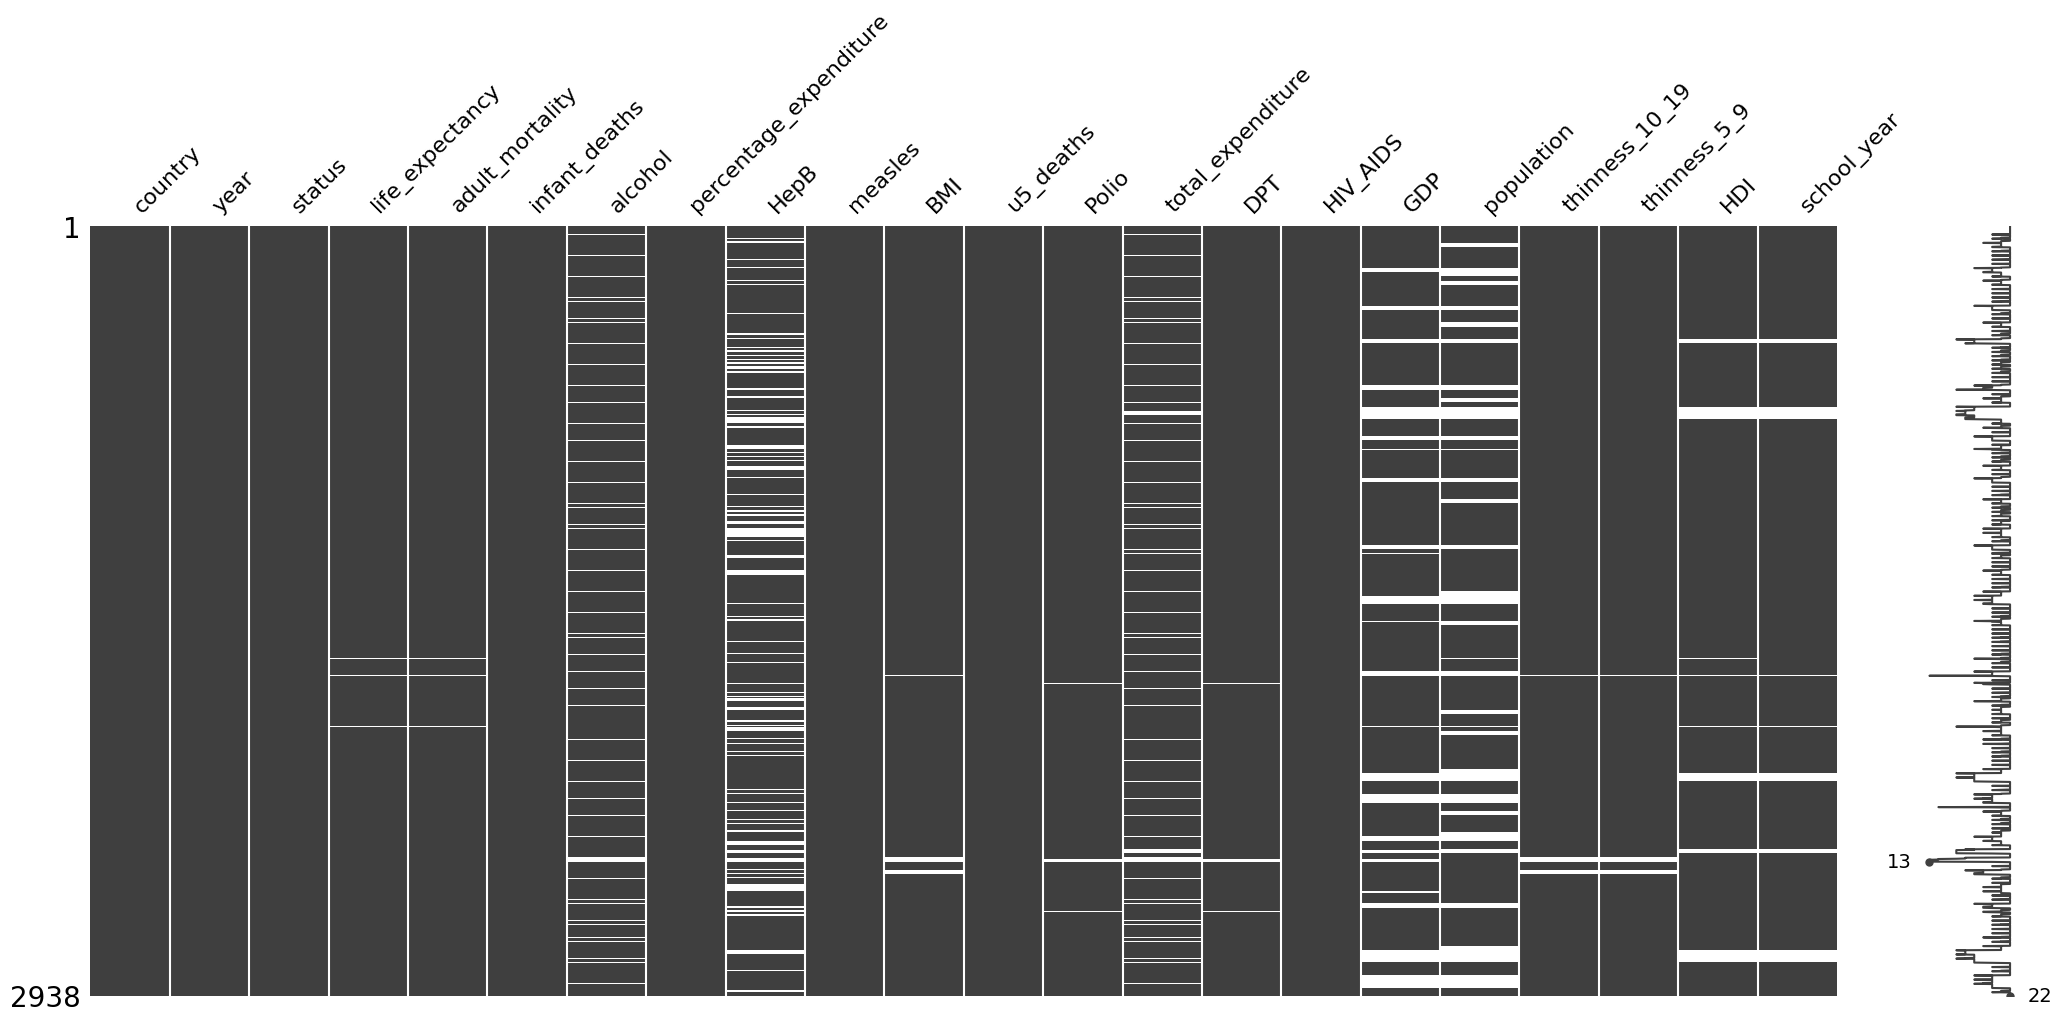

In [3]:
msno.matrix(data)

In [4]:
data = data[~data.life_expectancy.isna()]

<Axes: >

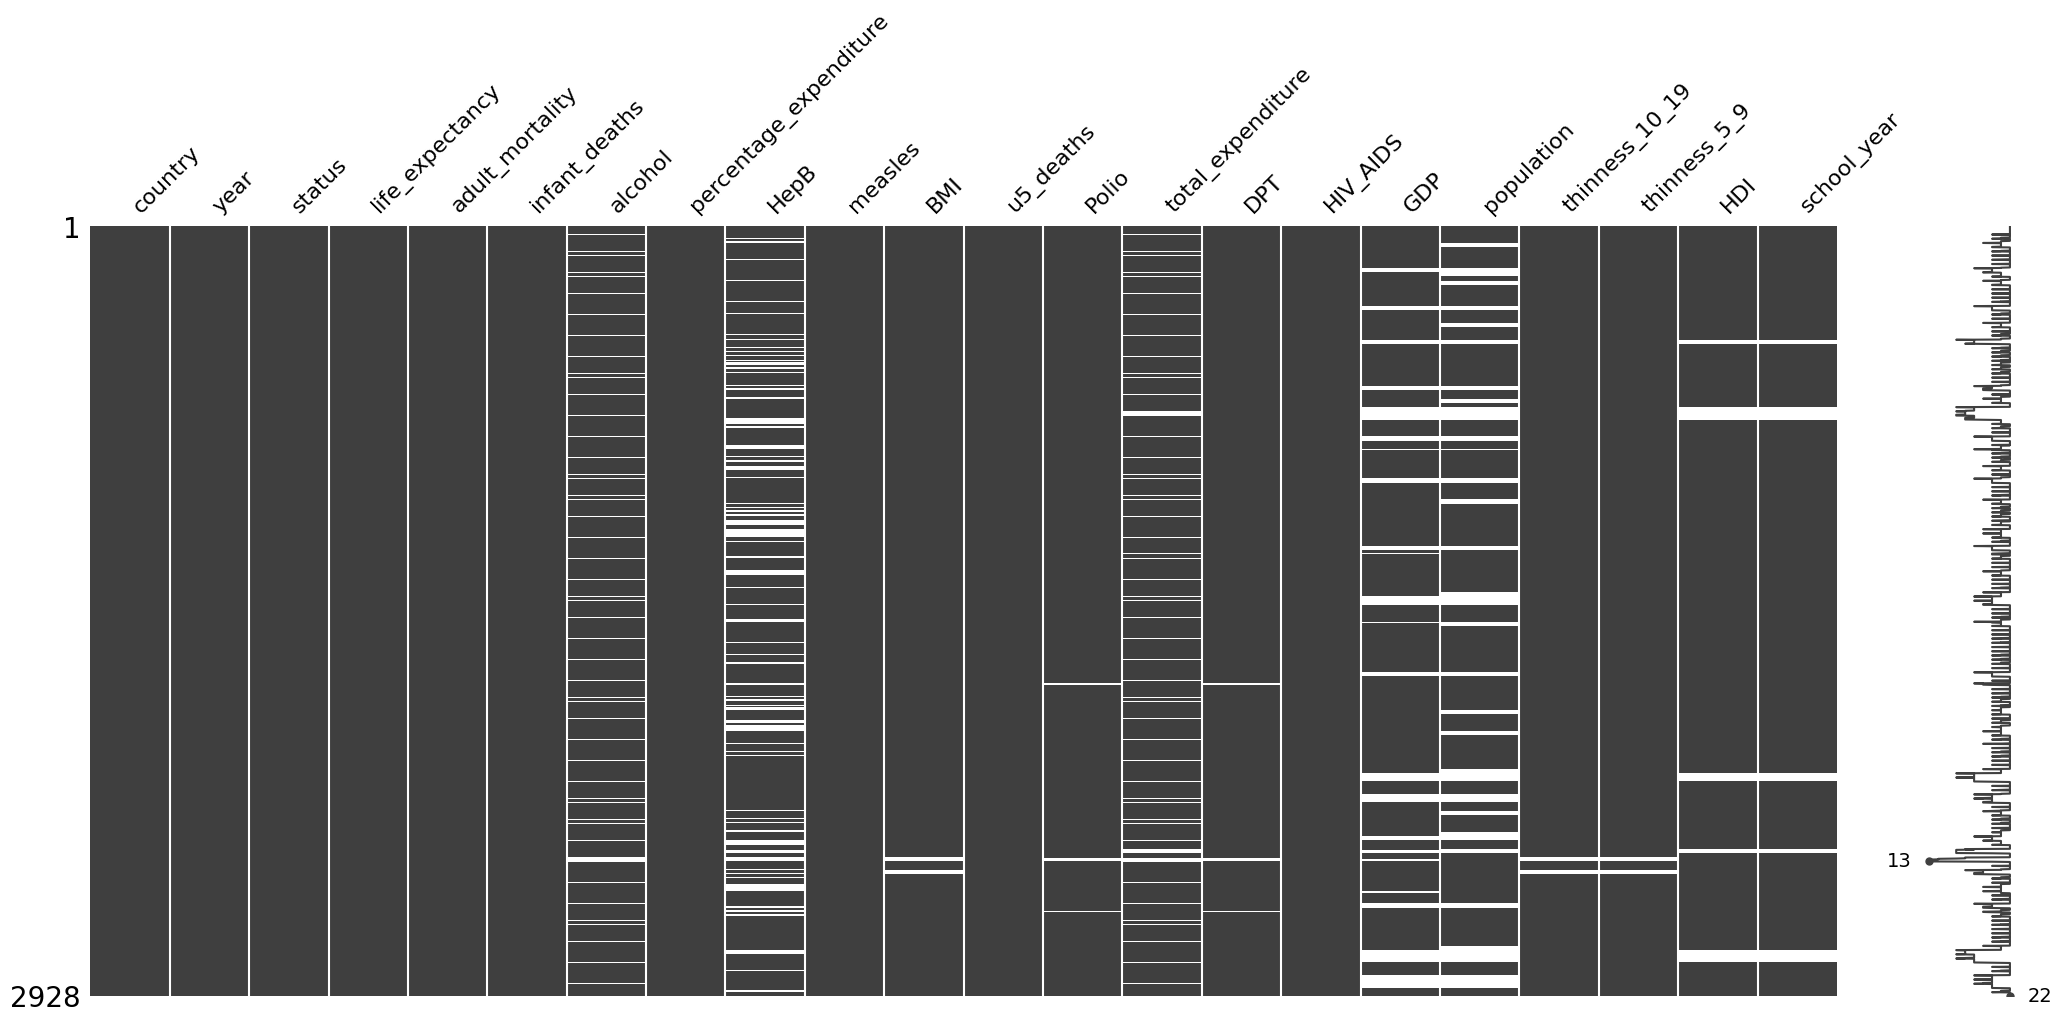

In [5]:
msno.matrix(data)

## **Splitting**

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="life_expectancy")
y = data["life_expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

In [9]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

## **Training No Poly**

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing for numerical features
numerical_features = ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP', 'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_features = ['country', 'status']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Define parameter grid
parameter = {
    'algo__max_depth': [3, 6, 9],
    'algo__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'algo__n_estimators': [50, 100, 200, 300],
    'algo__subsample': [0.6, 0.8, 1.0],
    'algo__gamma': [0, 0.1, 0.5, 1.0],
    'algo__colsample_bytree': [0.6, 0.8, 1.0],
    'algo__reg_alpha': [0, 0.01, 0.1, 1],
    'algo__reg_lambda': [0.1, 1.0, 10.0]
}

In [8]:
model = RandomizedSearchCV(pipeline, param_distributions=parameter, n_iter=50, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['year',
                                                                                'adult_mortality',
                                                                                'infant_deaths',
                                                                                'alcohol',
                                                                                'percentage_expenditure',
                                                                                'HepB',
                                                                                'measles',
                                                                                'BMI',
                                                                                'u5_deaths',
                                                                                'Polio',
                                                                                'total_expenditure',
                                                                                'DPT',
                                                                                'HIV_AID...
                                                           random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__colsample_bytree': [0.6, 0.8,
                                                                   1.0],
                                        'algo__gamma': [0, 0.1, 0.5, 1.0],
                                        'algo__learning_rate': [0.01, 0.05, 0.1,
                                                                0.2],
                                        'algo__max_depth': [3, 6, 9],
                                        'algo__n_estimators': [50, 100, 200,
                                                               300],
                                        'algo__reg_alpha': [0, 0.01, 0.1, 1],
                                        'algo__reg_lambda': [0.1, 1.0, 10.0],
                                        'algo__subsample': [0.6, 0.8, 1.0]},
                   verbose=1)

In [9]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'algo__subsample': 0.8, 'algo__reg_lambda': 0.1, 'algo__reg_alpha': 0.1, 'algo__n_estimators': 100, 'algo__max_depth': 9, 'algo__learning_rate': 0.05, 'algo__gamma': 0.5, 'algo__colsample_bytree': 0.6}
0.997984545013839 0.9624931690364216 0.9721285634655433


## **Feature Importance**

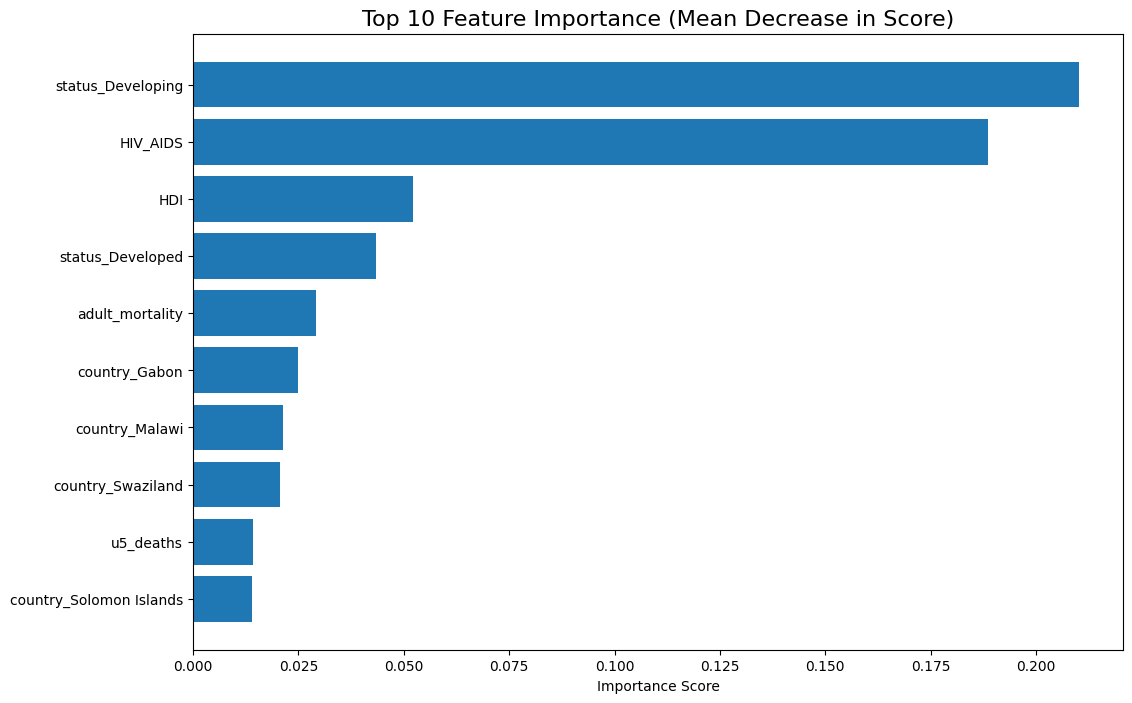

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the model with best parameters
best_model = model.best_estimator_

# Calculate feature importance using mean decrease in score (R²)
importances = best_model.named_steps['algo'].feature_importances_

# Get feature names from the preprocessor
numerical_features = ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
                      'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']

# For categorical features, the OneHotEncoder creates multiple columns for each category
categorical_features = ['country', 'status']

# Access OneHotEncoder from the preprocessor step and get feature names
onehot_encoder = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
categorical_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

# Combine numerical and categorical features
all_feature_names = np.concatenate([numerical_features, categorical_feature_names])

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Get the top 10 features
top_indices = indices[:10]

# Plot the top 10 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 10 Feature Importance (Mean Decrease in Score)", fontsize=16)
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), all_feature_names[top_indices])
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

## **Polynomial**

In [13]:
from sklearn.preprocessing import PolynomialFeatures

# Preprocessing for numerical features with PolynomialFeatures
numerical_features = ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP', 'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Add PolynomialFeatures with degree 2
])

# Preprocessing for categorical features
categorical_features = ['country', 'status']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Define parameter grid
parameter = {
    'algo__max_depth': [3, 6, 9],
    'algo__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'algo__n_estimators': [50, 100, 200, 300],
    'algo__subsample': [0.6, 0.8, 1.0],
    'algo__gamma': [0, 0.1, 0.5, 1.0],
    'algo__colsample_bytree': [0.6, 0.8, 1.0],
    'algo__reg_alpha': [0, 0.01, 0.1, 1],
    'algo__reg_lambda': [0.1, 1.0, 10.0],
    'preprocessor__num__poly__degree': [2]  # Tuning the degree of PolynomialFeatures
}

# Use RandomizedSearchCV for hyperparameter tuning
model = RandomizedSearchCV(pipeline, parameter, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
model.fit(X_train, y_train)

# Print the best parameters and scores
print(f"Best parameters: {model.best_params_}")
print(f"Training R²: {model.score(X_train, y_train)}")
print(f"Validation R²: {model.best_score_}")
print(f"Test R²: {model.score(X_test, y_test)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'preprocessor__num__poly__degree': 2, 'algo__subsample': 1.0, 'algo__reg_lambda': 1.0, 'algo__reg_alpha': 1, 'algo__n_estimators': 300, 'algo__max_depth': 9, 'algo__learning_rate': 0.05, 'algo__gamma': 0, 'algo__colsample_bytree': 0.6}
Training R²: 0.9999544981314531
Validation R²: 0.9619140616212316
Test R²: 0.9680835497728624
